In [28]:
### Import Necessary Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Black76 with Greeks
# https://www.glynholton.com/notes/black_1976/


In [29]:
### Load in Commodities Data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']
    # Drop rows with NaN values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    # Reset the index
    data.reset_index(inplace = True)
    
    return data


In [30]:
### Function to Get Most Recent Stock Price (S_0) and Set Strike (K)
def set_price_and_strike(commod_list, start_date, end_date, option_type):
    # Function Call to get FX Data
    commod_data = import_commod_data(commod_list, start_date, end_date)
    # Get the Futures Price (Most recent rate value)
    F_0 = commod_data[commod_list].iloc[-1]  # Extract the last value from the pair column
    # Set Strike Price 5% above (call) or 5% below (put) S_0
    if option_type == 'call':
        K = 1.05*F_0
    elif option_type == 'put':
        K = 0.95*F_0

    return commod_data, F_0, K

# Function Call
commod_list = ['HG=F']
start_date = '2023-07-01'
end_date = '2024-07-01'
commod_data, F_0, K = set_price_and_strike(commod_list, start_date, end_date, option_type = 'call')
print(commod_data.tail())
print('The Most Recent Price is:', round(F_0, 4))
print('The pre-determined Strike Price is:', round(K, 4))


[*********************100%%**********************]  1 of 1 completed

          Date    HG=F
246 2024-06-24  4.5270
247 2024-06-25  4.3810
248 2024-06-26  4.3675
249 2024-06-27  4.3285
250 2024-06-28  4.3905
The Most Recent Price is: HG=F    4.3905
Name: 250, dtype: float64
The pre-determined Strike Price is: HG=F    4.61
Name: 250, dtype: float64


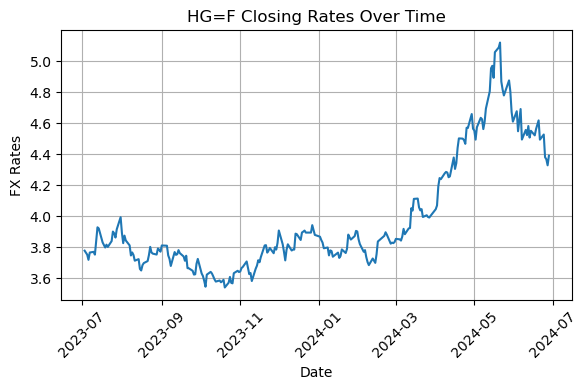

In [31]:
### Plot FX Rate Data
def plot_commod(df, commod_list):
    # Create Loop to Plot Each Individual FX Pair
    for commod in commod_list:
        plt.figure(figsize = (6, 4))

        plt.plot(df['Date'], df[commod]) # Need to adjust to spit out multiple graphs for each ticker
        plt.title(commod + ' Closing Rates Over Time')
        plt.xlabel('Date')
        plt.ylabel('FX Rates')

        plt.xticks(rotation = 45) # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()

    return plt.show()

plot_commod(commod_data, commod_list)


In [32]:
### Function to Compute Daily Returns
def daily_returns(commod_data):
    # Drop Date Column
    commod_data = commod_data.drop(columns = ['Date'])

    # Compute the daily returns of the forex data
    rets = commod_data.pct_change().dropna()

    return rets

returns = daily_returns(commod_data)
print(returns.tail())


         HG=F
246  0.007343
247 -0.032251
248 -0.003082
249 -0.008930
250  0.014324


In [33]:
### Function to compute sigma (std dev of log normal historical stock return data)
def compute_sigma(rets):
    sigma = np.std(rets) * np.sqrt(252)
    return sigma

sigma = compute_sigma(returns)
print(sigma)


HG=F    0.202091
dtype: float64


In [34]:
### Function to Create Black76 Model
def black76(option_type, r, F_0, K, T, sigma):
    # Define Values as Floats
    F_0 = float(F_0)
    K = float(K)
    T = float(T)
    sigma = float(sigma)
    # Calculate d_1 and d_2
    d_1 = (np.log(F_0 / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)
    # Calculate the option value
    if option_type == 'call':
        option_value = np.exp(-r * T) * (F_0 * norm.cdf(d_1) - K * norm.cdf(d_2))
    elif option_type == 'put':
        option_value = np.exp(-r * T) * (K * norm.cdf(-d_2) - F_0 * norm.cdf(-d_1))

    return option_value, d_1, d_2

# Function Call to Calculate Option Premium
r = 0.1
T = 1
option_value, d_1, d_2 = black76('call', r, F_0, K, T, sigma)
print('The calculated call option premium is:', round(option_value.item(), 4))
print('The calculated d_1 is:', round(d_1.item(), 4))
print('The calculated d_2 is:', round(d_2.item(), 4))


The calculated call option premium is: 0.2379
The calculated d_1 is: -0.1404
The calculated d_2 is: -0.3425


In [35]:
### Calculate Black76 Greeks
def b76_greeks(d_1, d_2, F_0, K, T, r, sigma):
    delta = norm.cdf(d_1)
    gamma = norm.pdf(d_1) / (F_0 * sigma * np.sqrt(T))
    theta = -((F_0 * norm.pdf(d_1) * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * norm.cdf(d_2)
    vega = F_0 * norm.pdf(d_1) * np.sqrt(T)
    rho = K * T * np.exp(-r * T) * norm.cdf(d_2)
    
    return delta, gamma, theta, vega, rho

delta, gamma, theta, vega, rho = b76_greeks(d_1, d_2, F_0, K, T, r, sigma)
print('The calculated delta is:', round(delta.item(), 4))
print('The calculated gamma is:', round(gamma.item(), 4))


The calculated delta is: 0.4442
The calculated gamma is: 0.4452


In [36]:
### Function to Calculate Dynamic Hedge Positions
def dyn_hedge_positions(F0, K, T, r, sigma, commod_data, option_type):
    positions = []
    deltas = []
    gammas = []

    # Initial calculation
    option_value, d_1, d_2 = black76(option_type, r, F0, K, T, sigma)
    initial_delta, initial_gamma, _, _, _ = b76_greeks(d_1, d_2, F0, K, T, r, sigma)

    # Set the initial position based on the delta
    if option_type == 'call':
        position = initial_delta
    elif option_type == 'put':
        position = -initial_delta

    # Loop through the data and calculate the positions
    for i in range(len(commod_data)):
        '''
        By iterating over commod_data, we update F to the current price of the underlying asset at each time step, 
        allowing us to recalculate the Greeks and adjust the hedge positions accordingly.
        '''
        F = commod_data.iloc[i] if isinstance(commod_data, pd.Series) else commod_data[i] # Get each futures value in the rows of the commodity data
        F = float(F)  # Ensure F is a float
        remaining_T = T - i / 252  # Assuming 252 trading days in a year
        option_value, d_1, d_2 = black76(option_type, r, F, K, remaining_T, sigma)
        delta, gamma, _, _, _ = b76_greeks(d_1, d_2, F, K, remaining_T, r, sigma)

        # Adjust the hedge position over time
        '''
        Hedge Ratio Values: The positions list contains the hedge ratio values. Each value indicates how much of 
                            the underlying asset should be held or shorted to hedge the position.
        Neg Delta Values: These values are the negative of the delta values calculated for the option at each time step. 
                          A negative delta indicates a short position, while a positive delta would indicate a long position.   
        '''
        positions.append(-delta)
        deltas.append(delta)
        gammas.append(gamma)

    return positions, deltas, gammas

### Call Function to Calculate Hedge Positions
positions, deltas, gammas = dyn_hedge_positions(F_0, K, T, r, sigma, commod_data['HG=F'], 'call')
print("Positions:", positions[:5])
print("Deltas:", deltas[:5])
print("Gammas:", gammas[:5])


Positions: [-0.1887427826083634, -0.1792396498903175, -0.16726178617465215, -0.18276396005235868, -0.18375336780935586]
Deltas: [0.1887427826083634, 0.1792396498903175, 0.16726178617465215, 0.18276396005235868, 0.18375336780935586]
Gammas: [HG=F    0.353879
dtype: float64, HG=F    0.345691
dtype: float64, HG=F    0.334441
dtype: float64, HG=F    0.350078
dtype: float64, HG=F    0.351546
dtype: float64]


In [37]:
### Function to Perform Backtesting of Dynamic Hedge
def backtest_dyn_hedge(F0, K, T, r, sigma, option_type, commod_data):
    daily_rets = daily_returns(commod_data)
    positions, deltas, gammas = dyn_hedge_positions(F0, K, T, r, sigma, commod_data.squeeze(), option_type)
    long_pos = 1000  # Fixed long position of 1000 commodity units
    short_pos = []
    long_rets = []
    short_rets = []

    # Loop over the data and backtest the dynamic hedge
    for i in range(len(daily_rets)):
        # Calculate the short position at each step (measured in commodity units)
        short_pos_val = long_pos * positions[i]
        short_pos.append(short_pos_val)

        # Calculate Daily Returns for the Long/Short Positions
        long_ret = daily_rets.iloc[i] * long_pos
        short_ret = daily_rets.iloc[i] * short_pos_val
        long_rets.append(long_ret)
        short_rets.append(short_ret)

    # Convert lists to pandas Series for cumulative return calculations
    long_rets = pd.Series(long_rets)
    short_rets = pd.Series(short_rets)

    # Calculate the hedge returns
    hedged_rets = long_rets - short_rets

    # Compute cumulative returns for the hedged and unhedged positions
    hedged_cumulative_rets = (1 + hedged_rets / long_pos).cumprod() * (long_pos + abs(pd.Series(short_pos)))
    unhedged_cumulative_rets = (1 + daily_rets.squeeze()).cumprod() * long_pos

    return short_pos, hedged_cumulative_rets, unhedged_cumulative_rets

### Call Function to Backtest Dynamic Hedge
short_pos, hedged_cumulative_rets, unhedged_cumulative_rets = backtest_dyn_hedge(F_0, K, T, r, sigma, 'call', commod_data['HG=F'])
print("Short Positions:", short_pos[:5])
print("Hedged Cumulative Returns:", hedged_cumulative_rets[:5])
print("Unhedged Cumulative Returns:", unhedged_cumulative_rets[:5])


Short Positions: [-188.74278260836343, -179.23964989031748, -167.26178617465214, -182.76396005235867, -183.75336780935586]
Hedged Cumulative Returns: 0    1179.207357
1    1157.468860
2    1162.608679
3    1179.713591
4    1174.029886
dtype: float64
Unhedged Cumulative Returns: 1    993.252168
2    984.387400
3    996.824535
4    998.015366
5    993.252168
Name: HG=F, dtype: float64
